In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


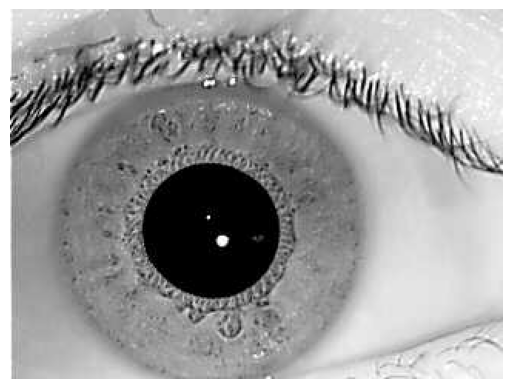

In [3]:
import cv2
import matplotlib.pyplot as plt
im1 = cv2.imread('/home/nishkal/dd/iris-code/datasets/IITD/001/01_L.bmp')

img_rgb = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()

In [4]:
import os
import re

# Generate good pairs:
good_pairs = []
imposter_pairs = []

# Get all filenames
folder_path = 'datasets/IITD/Normalized_Images'
all_entries = os.listdir(folder_path)
filenames = [entry for entry in all_entries if os.path.isfile(os.path.join(folder_path, entry))]
for filename in filenames: 
    match = re.search(r'(\d+)_(\d+)\.bmp', filename)
    if match:
        user = match.group(1)
        img_no = match.group(2)
        #print(f"Filename: {filename}, Numbers: {user}, {img_no}")

print(len(filenames))


1120


Image Pairs - Good and Imposters

In [5]:
import itertools
import random
def generate_pairs(filenames, imposter_pairs_to_generate, seed =42):
    random.seed(seed)

    user_images ={}
    for filename in filenames:
        match = re.search(r'(\d+)_(\d+)\.bmp', filename)

        if match: 
            user = match.group(1)
            if user not in user_images:
                user_images[user] = []
            user_images[user].append(filename)
    
    users = list(user_images.keys())
    
    true_pairs = []
    imposter_pairs = []

    # Generate true pairs:

    for user in users:
        images = user_images[user]

        if len(images) >= 2:
            for pair in itertools.combinations(images,2):
                true_pairs.append(sorted(list(pair)))

    # Generate imposter pairs
    generated_pairs = set() # To check unique pairs

    for curr_user in users:
        other_users = [u for u in users if u != curr_user]

        if not other_users:
            continue
        
        imposter_pair_count = 0

        while imposter_pair_count < imposter_pairs_to_generate:
            anchor_image = random.choice(user_images[curr_user])
            imposter_user = random.choice(other_users)
            
            imposter_image = random.choice(user_images[imposter_user])
            
            pair = tuple(sorted([anchor_image, imposter_image]))
            
            # Use a set to check for and add unique pairs efficiently
            if pair not in generated_pairs:
                imposter_pairs.append(list(pair))
                generated_pairs.add(pair)
                imposter_pair_count += 1
    
    return true_pairs, imposter_pairs

In [22]:
imposter_pairs_per_user = 10
true_pairs, imposter_pairs = generate_pairs(filenames, imposter_pairs_per_user)
print(f"Some imposter pairs: {imposter_pairs[0:10]}")
print(f"Some true pairs: {true_pairs[0:10]}")
print(f"Total true pairs = {len(true_pairs)}, Total imposter pairs = {len(imposter_pairs)}")


Some imposter pairs: [['212_5.bmp', '216_4.bmp'], ['147_4.bmp', '216_2.bmp'], ['026_1.bmp', '216_4.bmp'], ['081_4.bmp', '216_4.bmp'], ['096_3.bmp', '216_4.bmp'], ['024_4.bmp', '216_2.bmp'], ['212_2.bmp', '216_3.bmp'], ['056_3.bmp', '216_2.bmp'], ['078_4.bmp', '216_1.bmp'], ['030_5.bmp', '216_3.bmp']]
Some true pairs: [['216_2.bmp', '216_4.bmp'], ['216_4.bmp', '216_5.bmp'], ['216_1.bmp', '216_4.bmp'], ['216_3.bmp', '216_4.bmp'], ['216_2.bmp', '216_5.bmp'], ['216_1.bmp', '216_2.bmp'], ['216_2.bmp', '216_3.bmp'], ['216_1.bmp', '216_5.bmp'], ['216_3.bmp', '216_5.bmp'], ['216_1.bmp', '216_3.bmp']]
Total true pairs = 2240, Total imposter pairs = 2240


 Gabor Wavelet Functions

In [7]:
%pip install scipy
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np 
from scipy import ndimage as ndi
from skimage.util import view_as_blocks


def defined_gabor_kernel(frequency, sigma_x=None, sigma_y=None, n_stds=3, offset=0, theta=0):
    x0 = np.ceil(max(np.abs(n_stds * sigma_x * np.cos(theta)),
                        np.abs(n_stds * sigma_y * np.sin(theta)), 1))
    y0 = np.ceil(max(np.abs(n_stds * sigma_y * np.cos(theta)),
                        np.abs(n_stds * sigma_x * np.sin(theta)), 1))
    y, x = np.mgrid[-y0:y0 + 1, -x0:x0 + 1]
    g = np.zeros(y.shape, dtype=np.complex128)
    g[:] = np.exp(-0.5 * (x ** 2 / sigma_x ** 2 + y ** 2 / sigma_y ** 2))
    g /= 2 * np.pi * sigma_x * sigma_y
    g *= (np.cos(2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5)) + 
        1j * np.sin(2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5)))
    return g

def defined_gabor(img, frequency, sigma_x, sigma_y):
    g = defined_gabor_kernel(frequency, sigma_x, sigma_y)
    filtered_real = ndi.convolve(img.astype(np.float64), np.real(g), mode='wrap', cval=0)
    filtered_imag = ndi.convolve(img.astype(np.float64), np.imag(g), mode='wrap', cval=0)
    return filtered_real, filtered_imag

def getBitBlocks(filtered, size=8):
    blocks = view_as_blocks(filtered, block_shape=(size, size)).reshape([-1, size**2])
    blocks = np.mean(blocks, axis=-1) - np.mean(filtered)
    return np.maximum(np.sign(blocks), 0)


Helper functions

In [9]:
def ImageEnhancement(normalized):
    if normalized.ndim == 2:
        res = normalized.astype(np.uint8)
        im = cv2.equalizeHist(res)
        return im
    else:
        enhanced = []
        for res in normalized:
            res = res.astype(np.uint8)
            im = cv2.equalizeHist(res)
            enhanced.append(im)
        return np.stack(enhanced).squeeze()

In [10]:
def get_daugman_iris_code(filtered_real, filtered_imag, n_bits_per_pixel=2):
    """
    Generates a binary iris code from the real and imaginary parts of
    Gabor filtered images, using Daugman's phase-encoding scheme.

    Args:
        filtered_real (np.ndarray): The real part of the Gabor filtered image.
        filtered_imag (np.ndarray): The imaginary part of the Gabor filtered image.
        n_bits_per_pixel (int): The number of bits to generate per pixel (default 2).

    Returns:
        np.ndarray: A flattened, binary (0s and 1s) iris code array.
    """
    if filtered_real.shape != filtered_imag.shape:
        raise ValueError("Real and imaginary filtered images must have the same shape.")

    # Reshape the images into a 1D array for easier processing
    real_flat = filtered_real.flatten()
    imag_flat = filtered_imag.flatten()

    # Generate the first bit based on the sign of the real part
    real_code = (real_flat > 0).astype(np.uint8)

    # Generate the second bit based on the sign of the imaginary part
    imag_code = (imag_flat > 0).astype(np.uint8)

    # The final iris code is a concatenation of these two binary arrays.
    # We can interleave them or just concatenate them. Concatenation is simpler.
    iris_code = np.concatenate([real_code, imag_code])

    return iris_code

Check functions for one image

In [11]:
def process_single_normalized_image(normalized_image_path):
    """
    Loads a single normalized image and runs the feature extraction pipeline,
    printing the shape and type of the array at each stage for debugging.
    This version includes a fix for the plotting error.
    """
    try:
        print(f"--- Processing: {os.path.basename(normalized_image_path)} ---")
        
        # 1. Load the normalized image
        normalized_img_array = cv2.imread(normalized_image_path, cv2.IMREAD_GRAYSCALE)
        if normalized_img_array is None:
            print(f"ERROR: Could not load image from {normalized_image_path}. Check file path.")
            return

        print(f"1. Loaded Image: Shape = {normalized_img_array.shape}, Dtype = {normalized_img_array.dtype}")
        
        # 2. Image Enhancement
        enhanced_img = ImageEnhancement(normalized_img_array)
        print(f"2. Enhanced Image: Shape = {enhanced_img.shape}, Dtype = {enhanced_img.dtype}")

        # 3. Gabor Filtering
        filtered_real, _ = defined_gabor(enhanced_img, 0.4, 3, 1.5)
        print(f"3. Gabor Filter Real Part Output: Shape = {filtered_real.shape}, Dtype = {filtered_real.dtype}")
        
        # 4. Generate Bit Blocks
        # Bitblock output is a 1D float64 array of 0s and 1s.
        bitblock1 = getBitBlocks(filtered_real.astype(np.float64), size=8)
        print(f"4. BitBlock 1 (raw): Shape = {bitblock1.shape}, Dtype = {bitblock1.dtype}, Size = {bitblock1.size}")
        
        # 5. Correcting and testing the reshape
        y_blocks = enhanced_img.shape[0] // 8
        x_blocks = enhanced_img.shape[1] // 8
        bitblock1_vis = bitblock1.reshape(y_blocks, x_blocks)
        
        print(f"5. Reshaped BitBlock 1: Shape = {bitblock1_vis.shape}, Dtype = {bitblock1_vis.dtype}")
        
        # 6. Visualization
        # The fix: We now plot only the reshaped, 2D arrays.
        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        fig.suptitle(f"Debug: {os.path.basename(normalized_image_path)}")
        
        ax[0].imshow(enhanced_img, cmap='gray')
        ax[0].set_title('Enhanced Image')
        
        # Pass the correctly reshaped 2D array to imshow
        ax[1].imshow(bitblock1_vis, cmap='gray')
        ax[1].set_title('BitBlock 1 (Reshaped)')
        
        # Let's also check the filtered image itself for visualization
        ax[2].imshow(filtered_real, cmap='gray')
        ax[2].set_title('Filtered Real Part')
        
        for a in ax:
            a.axis('off')
        plt.show()

    except Exception as e:
        print(f"An unexpected error occurred during processing: {e}")

--- Processing: 001_1.bmp ---
1. Loaded Image: Shape = (48, 432), Dtype = uint8
2. Enhanced Image: Shape = (48, 432), Dtype = uint8
3. Gabor Filter Real Part Output: Shape = (48, 432), Dtype = float64
4. BitBlock 1 (raw): Shape = (324,), Dtype = float64, Size = 324
5. Reshaped BitBlock 1: Shape = (6, 54), Dtype = float64


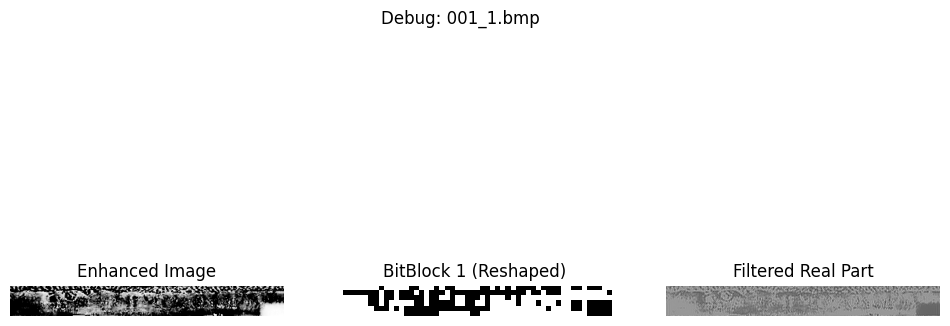

--- Processing: 001_2.bmp ---
1. Loaded Image: Shape = (48, 432), Dtype = uint8
2. Enhanced Image: Shape = (48, 432), Dtype = uint8
3. Gabor Filter Real Part Output: Shape = (48, 432), Dtype = float64
4. BitBlock 1 (raw): Shape = (324,), Dtype = float64, Size = 324
5. Reshaped BitBlock 1: Shape = (6, 54), Dtype = float64


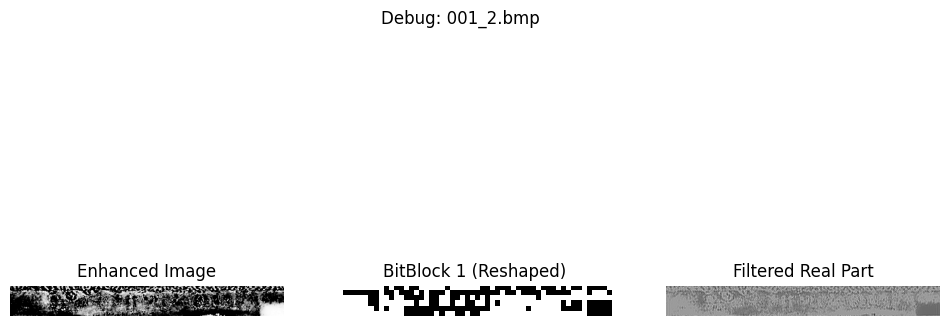

In [12]:
normalized_image_path = 'datasets/IITD/Normalized_Images/001_1.bmp'
iris_code1 = process_single_normalized_image(normalized_image_path)
iris_code2 = process_single_normalized_image('datasets/IITD/Normalized_Images/001_2.bmp')

In [13]:
def calculate_hamming_distance(iris_code1, iris_code2):
    """Calculates the normalized Hamming Distance."""
    xor_result = np.bitwise_xor(iris_code1, iris_code2)
    num_differing_bits = np.sum(xor_result)
    total_bits = len(iris_code1)
    
    if total_bits == 0:
        return 1.0
        
    hamming_distance = num_differing_bits / total_bits
    return hamming_distance

def process_and_save_iris_code(filename, normalized_dir, codes_dir):

    """Loads a normalized image, computes its iris code, and saves it."""

    file_path = os.path.join(normalized_dir, filename)

    normalized_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    

    if normalized_img is None:

        print(f"Failed to load image: {file_path}")

        return



    enhanced_img = ImageEnhancement(normalized_img)

    

    # Apply two Gabor filters, each with its own real and imaginary part

    filter1_real, filter1_imag = defined_gabor(enhanced_img, 0.4, 3, 1.5)

    filter2_real, filter2_imag = defined_gabor(enhanced_img, 0.4, 4.5, 1.5)

    

    # Generate iris codes using the corrected Daugman method

    iris_code1 = get_daugman_iris_code(filter1_real, filter1_imag)

    iris_code2 = get_daugman_iris_code(filter2_real, filter2_imag)

    

    # Concatenate the outputs from both Gabor filters to create the final iris code

    iris_code = np.concatenate([iris_code1, iris_code2])

    

    code_filename = os.path.splitext(filename)[0] + '.npy'

    code_path = os.path.join(codes_dir, code_filename)

    np.save(code_path, iris_code)

    print(f"Processed and saved iris code for {filename}") 

In [14]:
import os
import re
import cv2
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import view_as_blocks
from pathlib import Path

Generating and saving iris codes for all images...
Processed and saved iris code for 216_4.bmp
Processed and saved iris code for 122_5.bmp
Processed and saved iris code for 099_4.bmp
Processed and saved iris code for 160_1.bmp
Processed and saved iris code for 044_5.bmp
Processed and saved iris code for 052_3.bmp
Processed and saved iris code for 041_2.bmp
Processed and saved iris code for 212_3.bmp
Processed and saved iris code for 096_3.bmp
Processed and saved iris code for 077_4.bmp
Processed and saved iris code for 032_1.bmp
Processed and saved iris code for 150_4.bmp
Processed and saved iris code for 104_4.bmp
Processed and saved iris code for 211_4.bmp
Processed and saved iris code for 048_4.bmp
Processed and saved iris code for 017_1.bmp
Processed and saved iris code for 105_4.bmp
Processed and saved iris code for 018_3.bmp
Processed and saved iris code for 098_4.bmp
Processed and saved iris code for 070_4.bmp
Processed and saved iris code for 127_3.bmp
Processed and saved iris 

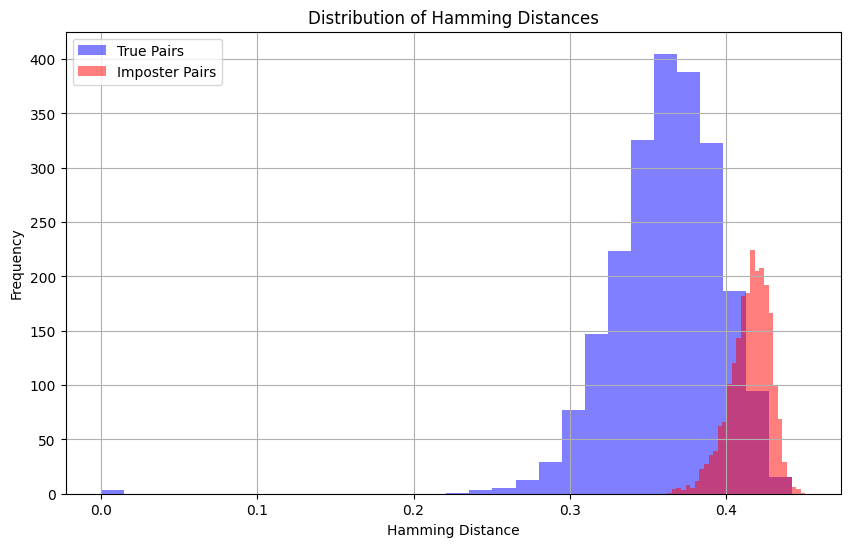

In [15]:
def pipeline():
    # Directories for normalized images and iris codes
    normalized_dir = 'datasets/IITD/Normalized_Images'
    codes_dir = 'iris_codes/'
    
    Path(codes_dir).mkdir(parents=True, exist_ok=True)
    
    all_entries = os.listdir(normalized_dir)
    filenames = [entry for entry in all_entries if os.path.isfile(os.path.join(normalized_dir, entry))]
    
    imposter_pairs_per_user = 10
    true_pairs, imposter_pairs = generate_pairs(filenames, imposter_pairs_per_user)
    
    print("Generating and saving iris codes for all images...")
    for filename in filenames:
        process_and_save_iris_code(filename, normalized_dir, codes_dir)
    print("Iris code generation complete.")
    
    true_distances = []
    print("Calculating Hamming distances for true pairs...")
    for pair in true_pairs:
        file1, file2 = pair
        code1 = np.load(os.path.join(codes_dir, os.path.splitext(file1)[0] + '.npy'))
        code2 = np.load(os.path.join(codes_dir, os.path.splitext(file2)[0] + '.npy'))
        distance = calculate_hamming_distance(code1, code2)
        true_distances.append(distance)
    
    imposter_distances = []
    print("Calculating Hamming distances for imposter pairs...")
    for pair in imposter_pairs:
        file1, file2 = pair
        code1 = np.load(os.path.join(codes_dir, os.path.splitext(file1)[0] + '.npy'))
        code2 = np.load(os.path.join(codes_dir, os.path.splitext(file2)[0] + '.npy'))
        distance = calculate_hamming_distance(code1, code2)
        imposter_distances.append(distance)
        
    print("\n--- Evaluation Results ---")
    print(f"Total True Pairs: {len(true_pairs)}")
    print(f"Average True Pair Distance: {np.mean(true_distances):.4f}")
    print(f"Total Imposter Pairs: {len(imposter_pairs)}")
    print(f"Average Imposter Pair Distance: {np.mean(imposter_distances):.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(true_distances, bins=30, alpha=0.5, label='True Pairs', color='blue')
    plt.hist(imposter_distances, bins=30, alpha=0.5, label='Imposter Pairs', color='red')
    plt.title('Distribution of Hamming Distances')
    plt.xlabel('Hamming Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

pipeline()

Visualizing iris codes...


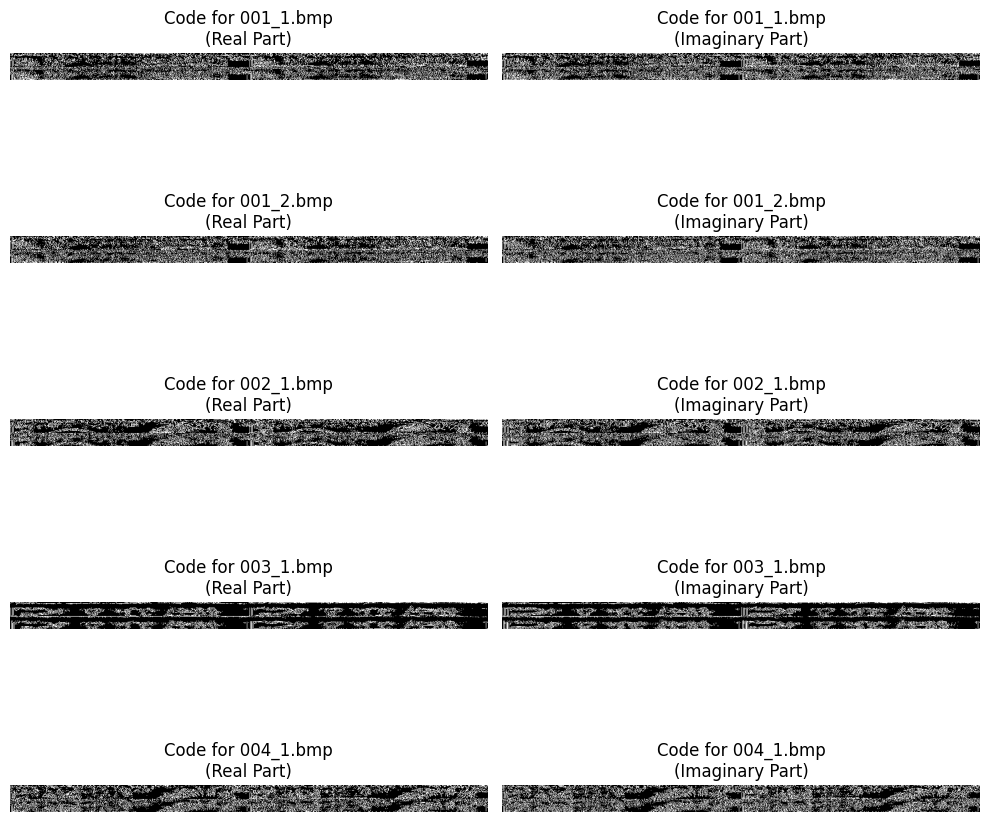

In [16]:
import matplotlib.pyplot as plt

def visualize_iris_codes(codes_dir, filenames_to_plot):
    """
    Loads and plots the iris codes for a list of specified filenames.

    Args:
        codes_dir (str): The directory where the .npy iris code files are saved.
        filenames_to_plot (list): A list of original filenames (e.g., '001_1.bmp').
    """
    fig, axs = plt.subplots(len(filenames_to_plot), 2, figsize=(10, len(filenames_to_plot) * 2))
    
    # Ensure axs is always a 2D array
    if len(filenames_to_plot) == 1:
        axs = np.array([axs])

    print("Visualizing iris codes...")
    
    for i, filename in enumerate(filenames_to_plot):
        try:
            code_filename = os.path.splitext(filename)[0] + '.npy'
            code_path = os.path.join(codes_dir, code_filename)
            
            iris_code = np.load(code_path)
            
            # The code is from two filters, and each filter's output is
            # 2 * 48 * 432 = 41472 bits. So the total length is 82944.
            # Your error log shows 41472, which suggests you are only saving
            # the output from ONE Gabor filter.
            # Let's assume the code is a single 41472-bit array from one filter.
            
            total_code_length = len(iris_code)
            
            # Since the code is based on the original image dimensions, we can
            # reshape it back to a format based on those dimensions.
            # The length is 48 * 432 * 2 (for real/imaginary parts).
            # Let's reshape it back to a format that has the image's height.
            
            img_height = 48
            
            # Split the code into its real and imaginary parts
            real_part_code = iris_code[:total_code_length // 2]
            imag_part_code = iris_code[total_code_length // 2:]
            
            # Reshape them back to the original image dimensions
            vis_real_code = real_part_code.reshape(img_height, total_code_length // (2 * img_height))
            vis_imag_code = imag_part_code.reshape(img_height, total_code_length // (2 * img_height))
            
            axs[i, 0].imshow(vis_real_code, cmap='gray')
            axs[i, 0].set_title(f"Code for {filename}\n(Real Part)")
            axs[i, 0].axis('off')

            axs[i, 1].imshow(vis_imag_code, cmap='gray')
            axs[i, 1].set_title(f"Code for {filename}\n(Imaginary Part)")
            axs[i, 1].axis('off')

        except FileNotFoundError:
            axs[i, 0].set_title(f"Code for {filename} not found.")
            axs[i, 0].axis('off')
            axs[i, 1].axis('off')
        except Exception as e:
            print(f"Error visualizing code for {filename}: {e}")

    plt.tight_layout()
    plt.show()

# Example usage:
codes_dir = 'iris_codes/'
filenames_to_visualize = ['001_1.bmp', '001_2.bmp', '002_1.bmp', '003_1.bmp', '004_1.bmp']
visualize_iris_codes(codes_dir, filenames_to_visualize)

In [17]:
def process_and_print_iris_code(normalized_image_path):
    """
    Loads a single normalized image, runs the feature extraction pipeline,
    and prints a portion of the resulting iris code.
    """
    try:
        # Load the pre-normalized image
        normalized_img_array = cv2.imread(normalized_image_path, cv2.IMREAD_GRAYSCALE)
        if normalized_img_array is None:
            print(f"Error: Could not load image from {normalized_image_path}")
            return
            
        enhanced_img = ImageEnhancement(normalized_img_array)
        
        # Apply two Gabor filters
        filter1_real, filter1_imag = defined_gabor(enhanced_img, 0.4, 3, 1.5)
        filter2_real, filter2_imag = defined_gabor(enhanced_img, 0.4, 4.5, 1.5)
        
        # Generate iris codes using the corrected Daugman method
        iris_code1 = get_daugman_iris_code(filter1_real, filter1_imag)
        iris_code2 = get_daugman_iris_code(filter2_real, filter2_imag)
        
        # Concatenate the outputs from both Gabor filters
        final_iris_code = np.concatenate([iris_code1, iris_code2])
        
        print(f"--- Iris Code for {os.path.basename(normalized_image_path)} ---")
        print(f"Total length of IrisCode: {len(final_iris_code)} bits")
        print(f"Data type of IrisCode: {final_iris_code.dtype}")
        print("\nFirst 100 bits of the IrisCode:")
        print(final_iris_code[:100])
        print("...")
        
    except Exception as e:
        print(f"An error occurred: {e}")

normalized_image_path = 'datasets/IITD/Normalized_Images/001_1.bmp'

# Run the function
process_and_print_iris_code(normalized_image_path)
process_and_print_iris_code('datasets/IITD/Normalized_Images/001_2.bmp')


--- Iris Code for 001_1.bmp ---
Total length of IrisCode: 82944 bits
Data type of IrisCode: uint8

First 100 bits of the IrisCode:
[0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1
 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1
 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0]
...
--- Iris Code for 001_2.bmp ---
Total length of IrisCode: 82944 bits
Data type of IrisCode: uint8

First 100 bits of the IrisCode:
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0
 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0]
...


In [18]:
def visualize_iris_code(iris_code):
    bits = np.unpackbits(iris_code)  # unpack bytes into bits (0 or 1)
    # reshape into a 2D array (e.g., 16 rows x 128 cols = 2048 bits)
    code_img = bits.reshape(8, 256)

    plt.imshow(code_img, cmap='gray', interpolation='nearest')
    plt.title("Iris Code Visualization")
    plt.axis('off')
    plt.show()



In [19]:
def calculate_hamming_distance2(iris_code1, iris_code2):
    xor_result = np.bitwise_xor(iris_code1, iris_code2)
    bits = np.unpackbits(xor_result)
    num_differing_bits = np.sum(bits)
    total_bits = len(bits)
    
    if total_bits == 0:
        return 1.0
        
    hamming_distance = num_differing_bits / total_bits
    return hamming_distance


Iris Code length (bytes): 256
First 16 bytes: [253 253 253 253 223 223 255 255 207  79  94  94 206  78  78  90]


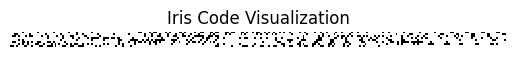

In [20]:
import cv2
import numpy as np

def daugman_iris_code(image_path, code_bytes=256):
    # Load grayscale image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {image_path}")

    # Resize to standard size (64 x 512)
    norm_img = cv2.resize(img, (512, 64), interpolation=cv2.INTER_CUBIC)

    # Parameters: multiple frequencies and orientations
    # frequencies = [0.05, 0.1, 0.15]  # cycles per pixel (wavelengths: 20, 10, ~6.6 px)
    frequency = 0.1
    orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°
    # orientations = [0]  # 0°, 45°, 90°, 135°
    sigma_x = 6.0
    sigma_y = 6.0
    kernel_size = 41

    bitstreams = []

    wavelength = 1.0 / frequency
    for theta in orientations:
            # Gabor kernels: real and imaginary parts
        gabor_real = cv2.getGaborKernel(
            (kernel_size, kernel_size),
            sigma_x, theta,
            wavelength,
            1.0, 0,
            ktype=cv2.CV_32F
        )
        gabor_imag = cv2.getGaborKernel(
            (kernel_size, kernel_size),
            sigma_x, theta,
            wavelength,
            1.0, np.pi/2,
            ktype=cv2.CV_32F
        )

        # Filter image with kernels
        filtered_real = cv2.filter2D(norm_img.astype(np.float32), cv2.CV_32F, gabor_real)
        filtered_imag = cv2.filter2D(norm_img.astype(np.float32), cv2.CV_32F, gabor_imag)

        # Phase quantization into 2 bits per pixel
        phase_real = (filtered_real >= 0).astype(np.uint8)
        phase_imag = (filtered_imag >= 0).astype(np.uint8)

        # Combine bits: real as MSB, imag as LSB
        bitstream = (phase_real << 1) | phase_imag
        bitstreams.append(bitstream.flatten())

    # Combine all bitstreams from different freqs & orientations by concatenation
    combined_bitstream = np.concatenate(bitstreams)

    # Generate fixed-length iris code (code_bytes bytes = code_bytes*8 bits)
    total_bits_needed = code_bytes * 8

    if len(combined_bitstream) > total_bits_needed:
        idx = np.linspace(0, len(combined_bitstream) - 1, total_bits_needed, dtype=int)
        combined_bitstream = combined_bitstream[idx]
    elif len(combined_bitstream) < total_bits_needed:
        raise ValueError("Image too small to generate full iris code without repetition.")

    # Pack bits into bytes
    iris_code = np.packbits(combined_bitstream)

    return iris_code

# Example usage:
image_path = "datasets/IITD/Normalized_Images/001_1.bmp"
code = daugman_iris_code(image_path)
print("Iris Code length (bytes):", len(code))
print("First 16 bytes:", code[:16])
visualize_iris_code(code)

Generating iris codes for all images...


Iris code generation complete.
Calculating Hamming distances for true pairs...
Calculating Hamming distances for imposter pairs...

--- Evaluation Results ---
Total True Pairs: 2240
Average True Pair Distance: 0.2610
Total Imposter Pairs: 2240
Average Imposter Pair Distance: 0.3630


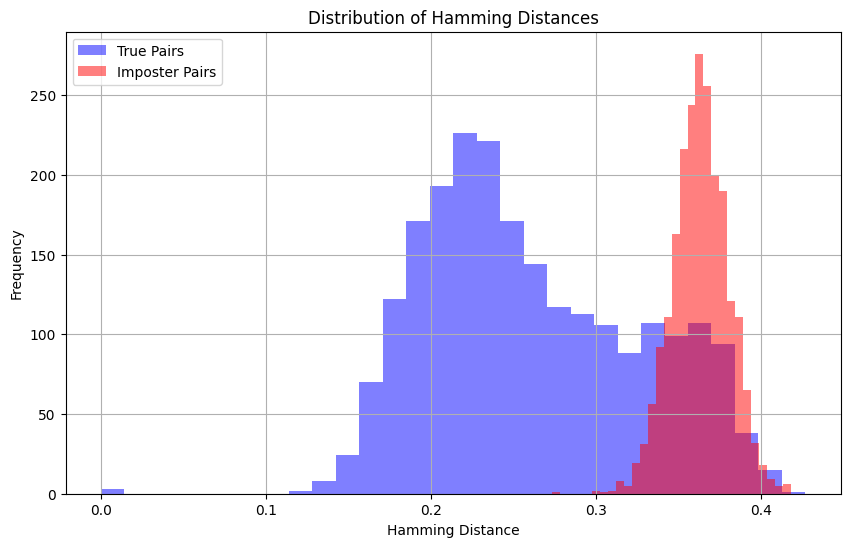

In [21]:
def new_pipeline():
    # Directories for normalized images and iris codes
    normalized_dir = 'datasets/IITD/Normalized_Images'
    
    # Path(codes_dir).mkdir(parents=True, exist_ok=True)
    
    # Find all the normalized image files
    all_entries = os.listdir(normalized_dir)
    filenames = [entry for entry in all_entries if os.path.isfile(os.path.join(normalized_dir, entry))]
    
    # Generate true and imposter pairs
    imposter_pairs_per_user = 10
    true_pairs, imposter_pairs = generate_pairs(filenames, imposter_pairs_per_user)
    
    # filenames = ['datasets/IITD/Normalized_Images/001_1.bmp', 'datasets/IITD/Normalized_Images/001_2.bmp']
    iris_codes = {}
    print("Generating iris codes for all images...")
    for filename in filenames:
        filename = os.path.join(normalized_dir, filename)
        iris_codes[filename] = daugman_iris_code(filename)
    print("Iris code generation complete.")
    
    true_distances = []
    print("Calculating Hamming distances for true pairs...")
    for pair in true_pairs:
        file1, file2 = pair
        file1 = os.path.join(normalized_dir, file1)
        file2 = os.path.join(normalized_dir, file2)
        # print(f'file1 = {file1}, file2 = {file2}')
        code_1 = iris_codes[file1]
        code_2 = iris_codes[file2]
        
        distance = calculate_hamming_distance2(code_1, code_2)
        true_distances.append(distance)
    
    imposter_distances = []
    print("Calculating Hamming distances for imposter pairs...")
    for pair in imposter_pairs:
        file1, file2 = pair
        file1 = os.path.join(normalized_dir, file1)
        file2 = os.path.join(normalized_dir, file2)

        # print(f'file1 = {file1}, file2 = {file2}')

        code_1 = iris_codes[file1]
        code_2 = iris_codes[file2]
        
        distance = calculate_hamming_distance2(code_1, code_2)
        imposter_distances.append(distance)
        
    print("\n--- Evaluation Results ---")
    print(f"Total True Pairs: {len(true_pairs)}")
    print(f"Average True Pair Distance: {np.mean(true_distances):.4f}")
    print(f"Total Imposter Pairs: {len(imposter_pairs)}")
    print(f"Average Imposter Pair Distance: {np.mean(imposter_distances):.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(true_distances, bins=30, alpha=0.5, label='True Pairs', color='blue')
    plt.hist(imposter_distances, bins=30, alpha=0.5, label='Imposter Pairs', color='red')
    plt.title('Distribution of Hamming Distances')
    plt.xlabel('Hamming Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

new_pipeline()